In [39]:
# import os
# os.environ['USE_PYGEOS']
import geopandas as gpd
from pathlib import Path
import numpy as np
import warnings
from tqdm.notebook import tqdm
import datetime
import os
import hvplot.xarray
import holoviews as hv

from scipy.interpolate import interp1d

import networkx as nx
import geonetworkx as gnx

warnings.filterwarnings("ignore")
hv.plotting.bokeh.element.ElementPlot.active_tools = ['pan']

In [40]:
river_network_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg.geojson')
river_network_pts_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg_pts.geojson')
# river_network_fn = Path('../../data-gunnison/cumberland_rivreg/cumberland_rivreg.geojson')
# river_network_pts_fn = Path('../../data-gunnison/cumberland_rivreg/cumberland_rivreg_pts.geojson')

river_network = gpd.read_file(river_network_fn)
river_network.to_xarray()

river_network_pts = gpd.read_file(river_network_pts_fn)
river_network_pts.to_xarray()

<xarray.Dataset>
Dimensions:    (index: 9)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7 8
Data variables:
    x          (index) object '-88.21874800000001' ... '-85.944131'
    y          (index) object '37.018747' '36.959995' ... '35.801042' '36.29222'
    name       (index) object 'Barkley_Dam' 'Laurel_Dam' ... 'Cordell_Hull_Dam'
    id         (index) int64 0 1 2 3 4 5 6 7 8
    elevation  (index) float64 106.0 301.0 196.0 195.0 ... 201.0 268.0 158.0
    geometry   (index) object POINT (-88.218748 37.018747) ... POINT (-85.944...

{0: Text(-0.7723619250380132, -0.38009905384727755, '0'),
 1: Text(1.0, 0.018160331485126406, '1'),
 2: Text(0.4726564685779117, 0.0434341018482646, '2'),
 3: Text(0.018875922887422618, -0.22947912715996854, '3'),
 4: Text(-0.499565623365581, -0.04235858828341923, '4'),
 5: Text(-0.8555457651918912, 0.060641330519743485, '5'),
 6: Text(0.237141151209354, -0.0242826610427531, '6'),
 7: Text(0.5147370645864435, 0.34729204252017026, '7'),
 8: Text(-0.11593729366564666, 0.20669162396011367, '8')}

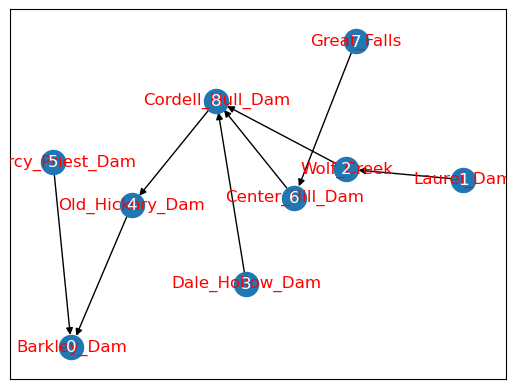

In [41]:
# quick and simple implementation without landlab

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
# nx.draw(G, nx.drawing.planar_layout(G))
pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [42]:
list(nx.topological_sort(G)) # upstream most is first element

[1, 3, 5, 7, 2, 6, 8, 4, 0]

Method:

- Generate topologically sorted list of nodes. This will provide a sequence of nodes with the downstream most node at the end.
- For each Node:
    - Obtain `natural_inflow` from RAT routing results.
    - Obtain `storage_change`. Satellite estimates
    - Get list of upstream nodes.
    - If any upstream nodes, for each upstream node:
        - Obtain **routed** `natural_inflow`.  ; routed = time-lagged
        - Obtain **routed** `outflow`.
    - Calculate `regulated_inflow` = `natural_inflow - sum(upstream_reservoirs['natural_inflow']) + sum(upstream_reservoirs['outflow'])`
    - Calculate `outflow` = `regulated_inflow - ∆S`

In [43]:
import xarray as xr
import pandas as pd

* Check how the structure of in-situ regulation data looks like
* mimic that for the satellite data

In [69]:
RUN_TYPE = 'IMERG-Final'

start_date = "2019-01-01"
end_date = "2021-09-30"

rat_output_dir = Path("../../data-imerg_final-2010_2021/tennessee/basins/cumberland/rat_outputs/")
natural_inflow_dir = rat_output_dir / "inflow"
storage_change_dir = Path("../../data-cumberland/tennessee/basins/cumberland/rat_outputs/") / "dels"  # storage change can be read from the same run since it will be the same for all runs - it is not dependent on preicpitation product used.
regulation_data_fn = Path("../../data-imerg_final-2010_2021/regulation/regulation_data.RAT.nc")
regulation_data_fn.parent.mkdir(exist_ok=True)
regulation_data_output_fn = regulation_data_fn.with_suffix(f".regulated.{RUN_TYPE}.nc")

insitu_dir = Path("../../data/insitu/")  # observed ∆S, I, O

# Compile data for running river regulation model and running the model

In [66]:
# Prepare regulation input
# Code to make the regulation_data.nc file.
datasets_to_join = []

for node_id in G:
    node = G.nodes[node_id]
    name = node['name']

    # natural inflow
    natural_inflow_fn = natural_inflow_dir / f"{name}.csv"
    natural_inflow = pd.read_csv(natural_inflow_fn, parse_dates=['date']).rename({
        'date': 'time',
        'streamflow': 'natural_inflow'
        }, axis='columns')
    natural_inflow['natural_inflow'] = natural_inflow['natural_inflow'] * (24*60*60) # m3/s -> m3/day
    natural_inflow['node'] = node_id
    natural_inflow.set_index(['time', 'node'], inplace=True)
    natural_inflow = natural_inflow.to_xarray()
    datasets_to_join.append(natural_inflow)

    # storage change
    storage_change_fn = storage_change_dir / f"{name}.csv"
    storage_change = pd.read_csv(storage_change_fn, parse_dates=['date']).rename({
        'date': 'time',
        'dS': 'storage_change'
    }, axis='columns')[['time', 'storage_change']]

    storage_change['storage_change'] = storage_change['storage_change'] * 1e9 # km3 -> m3
    # convert storage_change to daily - https://stackoverflow.com/a/73724900
    storage_change = storage_change.set_index('time')
    storage_change = storage_change.resample('1D').apply(lambda x: np.nan if x.empty else x)
    groups = storage_change['storage_change'].notna()[::-1].cumsum()
    storage_change['storage_change'] = storage_change['storage_change'].fillna(0).groupby(groups).transform('mean')
    storage_change['node'] = node_id
    storage_change = storage_change.reset_index().set_index(['time', 'node'])
    storage_change = storage_change.to_xarray()
    datasets_to_join.append(storage_change)

    # insitu data
    insitu_fn = insitu_dir / f"{name}.csv"
    insitu = pd.read_csv(insitu_fn, parse_dates=['date']).rename({'date': 'time'}, axis=1)

    insitu['node'] = node_id
    
    # observed inflow
    obs_inflow = insitu[['time', 'node', 'inflow']].rename({'inflow': 'obs_inflow'}, axis=1)
    obs_inflow.set_index(['time', 'node'], inplace=True)
    obs_inflow = obs_inflow.to_xarray() * (24*60*60) # m3/s -> m3/day
    datasets_to_join.append(obs_inflow)

    # observed outflow (if available)
    if 'outflow' in insitu.columns:
        obs_outflow = insitu[['time', 'node', 'outflow']].rename({'outflow': 'obs_outflow'}, axis=1)
        obs_outflow.set_index(['time', 'node'], inplace=True)
        obs_outflow = obs_outflow.to_xarray() * (24*60*60) # m3/s -> m3/day
        datasets_to_join.append(obs_outflow)

regulation_data = xr.merge(datasets_to_join)
regulation_data.to_netcdf(regulation_data_fn)

Todo next:
- [x] regulation.nc file made.
- [ ] complete next few cells of jupyter notebook to estimate river regulation using satellite derived ∆S.

In [67]:
regulation_data['storage_change'].dropna('time', 'any')

<xarray.DataArray 'storage_change' (time: 981, node: 9)>
array([[ 2.20397906e+07,  4.76832213e+06, -1.98828401e+08, ...,
        -6.92266933e+06, -3.10137320e+03,  3.65990044e+05],
       [-6.40897676e+06,  4.76832213e+06,  2.85880701e+08, ...,
        -6.88437598e+06, -3.10137320e+03,  3.68041627e+05],
       [ 2.90731101e+07,  4.76832213e+06,  2.85880701e+08, ...,
        -6.88437598e+06, -3.10137320e+03,  3.68041627e+05],
       ...,
       [-5.95264952e+07, -1.39287179e+07,  2.66125173e+08, ...,
         1.89250471e+07,  1.48511570e+04,  1.64287477e+06],
       [-5.95264952e+07, -1.39287179e+07,  2.66125173e+08, ...,
         1.89250471e+07,  1.48511570e+04,  1.64287477e+06],
       [-5.95264952e+07, -3.71258946e+06, -1.21114921e+09, ...,
         1.89250471e+07,  1.48511570e+04,  1.64287477e+06]])
Coordinates:
  * time     (time) datetime64[ns] 2019-01-23 2019-01-24 ... 2021-09-29
  * node     (node) int64 0 1 2 3 4 5 6 7 8

In [68]:
dt = '1d'

ds = xr.open_dataset(regulation_data_fn)

# add necessary dataarrays
if 'outflow' not in ds.variables:
    ds['outflow'] = xr.full_like(ds['natural_inflow'], np.nan)
if 'regulated_inflow' not in ds.variables:
    ds['regulated_inflow'] = xr.full_like(ds['natural_inflow'], np.nan)

def update(date, ds, G):
    # start calculating regulated streamflow from upstream dams
    for node in list(nx.topological_sort(G)):
        storage_change = float(ds['storage_change'].sel(node=node, time=date))
        natural_inflow = float(ds['natural_inflow'].sel(node=node, time=date))

        upstreams = list(G.predecessors(node))
        upstream_outflow = 0.0
        upstream_natural_inflow = 0.0
        if len(upstreams) > 0:
            time_lags = [date - pd.to_timedelta(round(G.get_edge_data(upstream, node)['travel_time']), 'd') for upstream in upstreams]
            upstream_outflow = sum([float(ds['outflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
            upstream_natural_inflow = sum([float(ds['natural_inflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
        
        regulated_inflow = max([0, float(natural_inflow - upstream_natural_inflow + upstream_outflow)])
        outflow = max([0, regulated_inflow - storage_change])

        ds['regulated_inflow'].loc[dict(node=node, time=date)] = regulated_inflow
        ds['outflow'].loc[dict(node=node, time=date)] = outflow


dates = pd.date_range(start_date, end_date, freq=dt)

with tqdm(total=len(dates)) as pbar:
    for date in dates:
        update(date, ds, G)
        pbar.update(1)
        pbar.set_description(f"{date}")

  0%|          | 0/1004 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# save results
ds.to_netcdf(regulation_data_output_fn)
ds.close()

# Read in regulation data for stats calculation

In [70]:
# Open regulation data for plotting
ds = xr.open_dataset(regulation_data_output_fn)
ds

<xarray.Dataset>
Dimensions:           (time: 30330, node: 9)
Coordinates:
  * time              (time) datetime64[ns] 1938-10-01 1938-10-02 ... 2021-10-14
  * node              (node) int64 0 1 2 3 4 5 6 7 8
Data variables:
    natural_inflow    (time, node) float64 ...
    storage_change    (time, node) float64 ...
    obs_inflow        (time, node) float64 ...
    obs_outflow       (time, node) float64 ...
    outflow           (time, node) float64 ...
    regulated_inflow  (time, node) float64 ...

In [71]:
subset = ds.sel(time=slice(start_date, end_date))
subset

<xarray.Dataset>
Dimensions:           (time: 1004, node: 9)
Coordinates:
  * time              (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2021-09-30
  * node              (node) int64 0 1 2 3 4 5 6 7 8
Data variables:
    natural_inflow    (time, node) float64 ...
    storage_change    (time, node) float64 ...
    obs_inflow        (time, node) float64 ...
    obs_outflow       (time, node) float64 ...
    outflow           (time, node) float64 ...
    regulated_inflow  (time, node) float64 ...

In [72]:
import scipy.stats as stats

def get_stats(obs, mod):
    corr, corr_p = stats.pearsonr(obs, mod)
    nse = 1 - (np.sum((obs - mod)**2)/np.sum((obs - np.mean(obs))**2))
    nse1 = 1 - (np.sum(np.abs(obs - mod))/np.sum(np.abs(obs - np.mean(obs))))
    rmse = np.sqrt(np.sum((obs-mod)**2)/len(mod))
    norm_rmse = rmse/(np.max(obs) - np.min(obs))
    mae = np.sum(np.abs(mod-obs))/len(mod)
    norm_mae = mae/(np.max(obs) - min(obs))
    kge = 1 - np.sqrt((corr-1)**2 +  (np.std(mod)/np.std(obs) - 1)**2 + (np.mean(mod)/np.mean(obs) - 1)**2) 

    print({'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge})

    return {'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge}

# Calculate comparison statistics

In [25]:
start_date = "2019-01-01"
end_date = "2019-09-30"
subset = subset.sel(time=slice(start_date, end_date))

dims = ['run_type', 'station', 'flow_type']
stat_vars = ['pearson-r', 'pearson-r p-val', 'nse', 'nse1', 'rmse', 'norm_rmse', 'mae', 'norm_mae', 'kge']

results_stats_data = {k: [] for k in dims + stat_vars} # make dictionary to store results

for node in G.nodes:
    station = G.nodes[node]['name']

    # f, ax = plt.subplots(figsize=(12, 6))

    reg_inflow = (subset['regulated_inflow'].sel(node=node) * 1e-6)
    nat_inflow = (subset['natural_inflow'].sel(node=node) * 1e-6)
    obs_inflow = (subset['obs_inflow'].sel(node=node) * 1e-6)

    no_nan_reg_obs = xr.merge([reg_inflow, obs_inflow]).dropna(dim="time")
    if no_nan_reg_obs.count('time')['obs_inflow'] > 2:
        reg_inflow_stats = get_stats(no_nan_reg_obs['obs_inflow'].data, no_nan_reg_obs['regulated_inflow'].data)
    
    no_nan_nat_obs = xr.merge([nat_inflow, obs_inflow]).dropna(dim="time")
    if no_nan_nat_obs.count('time')['obs_inflow'] > 2:
        nat_inflow_stats = get_stats(no_nan_nat_obs['obs_inflow'].data, no_nan_nat_obs['natural_inflow'].data)

    # store results for regulated flow
    results_stats_data['run_type'].append(RUN_TYPE)
    results_stats_data['station'].append(station)
    results_stats_data['flow_type'].append('regulated')
    for var in stat_vars:
        results_stats_data[var].append(reg_inflow_stats[var])

    # store results for natural flow
    results_stats_data['run_type'].append(RUN_TYPE)
    results_stats_data['station'].append(station)
    results_stats_data['flow_type'].append('natural')
    for var in stat_vars:
        results_stats_data[var].append(nat_inflow_stats[var])

    # reg_inflow.plot(ax=ax, label=f'Regulated inflow (Mn. m3/day), r:{reg_inflow_stats["pearson-r"]:.2f}, kge:{reg_inflow_stats["kge"]:.4f}, norm_rmse:{reg_inflow_stats["norm_rmse"]:.4f}')
    # nat_inflow.plot(ax=ax, label=f'Natural inflow (from VIC) (Mn. m3/day), r:{nat_inflow_stats["pearson-r"]:.2f}, kge:{nat_inflow_stats["kge"]:.4f}, norm_rmse:{nat_inflow_stats["norm_rmse"]:.4f}', linestyle='dotted')
    # obs_inflow.plot(ax=ax, label=f'Observed inflow (Mn. m3/day)')
    # ax.set_title(f'Station/reservoir: {G.nodes[node]["name"]}. {len(list(G.predecessors(node)))} Upstream dams')
    # ax.set_ylabel("Inflow (Million m3/day)")
    # ax.legend()

    # save_dir = Path("../../results/04_era5")
    # save_dir.mkdir(exist_ok=True)
    # save_fn = save_dir / f"{node:0>2}_{G.nodes[node]['name']}.png"
    # plt.savefig(save_fn)

{'pearson-r': 0.46049336936972163, 'pearson-r p-val': 9.803170659092054e-16, 'nse': -0.9774957255604577, 'nse1': -0.18431757733330212, 'rmse': 154.12978995721627, 'norm_rmse': 0.2804447925705875, 'mae': 102.7735442899863, 'norm_mae': 0.18700022440924538, 'kge': 0.18808498544929475}
{'pearson-r': 0.8680779029795471, 'pearson-r p-val': 2.1039000445036347e-84, 'nse': 0.6300936094096279, 'nse1': 0.45083047583815394, 'rmse': 66.66144554279239, 'norm_rmse': 0.12129293936553921, 'mae': 47.65621949244638, 'norm_mae': 0.08671223514913884, 'kge': 0.7387790353153592}
{'pearson-r': 0.6114173809298153, 'pearson-r p-val': 2.819840126650105e-29, 'nse': 0.3109247830720211, 'nse1': 0.28761965869326633, 'rmse': 2.4585907074067554, 'norm_rmse': 0.12816130542154272, 'mae': 1.3252005306820445, 'norm_mae': 0.06907999344741415, 'kge': 0.5855609819525986}
{'pearson-r': 0.6114173809298153, 'pearson-r p-val': 2.819840126650105e-29, 'nse': 0.3109247830720211, 'nse1': 0.28761965869326633, 'rmse': 2.45859070740675

In [26]:
# convert results into dataset
resds = pd.DataFrame(results_stats_data).set_index(dims).to_xarray()

# add attributes
resds['pearson-r'].attrs = {'long_name': 'Pearson correlation coefficient', 'min': -1, 'max': 1, 'unit': '1'}
resds['pearson-r p-val'].attrs = {'long_name': 'Pearson correlation coefficient p-value', 'min': 0, 'max': 1, 'unit': '1'}
resds['nse'].attrs = {'long_name': 'Nash-Sutcliffe efficiency', 'min': -np.inf, 'max': 1, 'unit': '1'}
resds['nse1'].attrs = {'long_name': 'Nash-Sutcliffe efficiency (NSE1)', 'min': -np.inf, 'max': 1, 'unit': '1'}
resds['rmse'].attrs = {'long_name': 'Root mean squared error', 'min': 0, 'max': np.inf, 'unit': '1'}
resds['norm_rmse'].attrs = {'long_name': 'Normalized root mean squared error', 'min': 0, 'max': 1, 'unit': '1'}
resds['mae'].attrs = {'long_name': 'Mean absolute error', 'min': 0, 'max': np.inf, 'unit': '1'}
resds['norm_mae'].attrs = {'long_name': 'Normalized mean absolute error', 'min': 0, 'max': 1, 'unit': '1'}
resds['kge'].attrs = {'long_name': 'Kling-Gupta efficiency', 'min': -np.inf, 'max': 1, 'unit': '1'}

# add coordinate attributes
resds.coords['run_type'].attrs = {'long_name': 'Run type', 'description': 'Type of run to compare between different model runs. For example: `ERA5`, `IMERG-Late`, `IMERG-Final` etc. denoting which type of precipitation product used.'}
resds.coords['station'].attrs = {'long_name': 'Station/reservoir name', 'description': 'Name of station/reservoir'}
resds.coords['flow_type'].attrs = {'long_name': 'Flow type', 'description': 'Regulated or Natural flow'}

# add dataset attributes
resds.attrs = {
    'description': 'Statistics for inflow at each station/reservoir for the specifed time period.', 
    'date_created': str(datetime.datetime.now())
}

try:
    START_DATE = str(subset['time'].min().values)
    END_DATE = str(subset['time'].max().values)
    resds.attrs['from_date'] = START_DATE
    resds.attrs['to_date'] = END_DATE
except:
    pass

resds

<xarray.Dataset>
Dimensions:          (run_type: 1, station: 9, flow_type: 2)
Coordinates:
  * run_type         (run_type) object 'ERA5'
  * station          (station) object 'Barkley_Dam' ... 'Wolf_Creek'
  * flow_type        (flow_type) object 'natural' 'regulated'
Data variables:
    pearson-r        (run_type, station, flow_type) float64 0.8681 ... 0.652
    pearson-r p-val  (run_type, station, flow_type) float64 2.104e-84 ... 2.6...
    nse              (run_type, station, flow_type) float64 0.6301 ... 0.4149
    nse1             (run_type, station, flow_type) float64 0.4508 ... 0.3272
    rmse             (run_type, station, flow_type) float64 66.66 ... 44.82
    norm_rmse        (run_type, station, flow_type) float64 0.1213 ... 0.1127
    mae              (run_type, station, flow_type) float64 47.66 102.8 ... 25.4
    norm_mae         (run_type, station, flow_type) float64 0.08671 ... 0.06385
    kge              (run_type, station, flow_type) float64 0.7388 ... 0.5727
Attributes:
    description:   Statistics for inflow at each station/reservoir for the sp...
    date_created:  2023-08-29 15:02:13.170070
    from_date:     2019-01-01T00:00:00.000000000
    to_date:       2019-09-30T00:00:00.000000000

In [27]:
# save resulting statistics 
save_dir = Path("../../results/rr_stats_entire_period")
save_dir.mkdir(exist_ok=True, parents=True)
# nc
save_fp = save_dir / f"RAT.{str(RUN_TYPE)}.nc"
resds.to_netcdf(save_fp)
# csv
save_fp = save_dir / f"RAT.{str(RUN_TYPE)}.csv"
resds.to_dataframe().to_csv(save_fp)

# Comparison statistics, year partitioned into wet vs. dry seasons

- dry season - low precipitation + snowmelt: Oct - Mar
- wet season - high precipitation + snowmelt: Apr - Sep

In [73]:
start_date = "2019-01-01"
end_date = "2019-09-30"
subset = subset.sel(time=slice(start_date, end_date))

dims = ['run_type', 'station', 'flow_type', 'season']
stat_vars = ['pearson-r', 'pearson-r p-val', 'nse', 'nse1', 'rmse', 'norm_rmse', 'mae', 'norm_mae', 'kge']

results_stats_data = {k: [] for k in dims + stat_vars} # make dictionary to store results
season_months = {
    'dry': lambda month: (month >= 10) | (month <= 3),
    'wet': lambda month: (month >= 4) & (month <= 9)
}

for node in G.nodes:
    station = G.nodes[node]['name']

    for season in ['wet', 'dry']:
        reg_inflow = (subset['regulated_inflow'].sel(node=node).sel(time=season_months[season](subset['regulated_inflow']['time.month'])) * 1e-6)
        nat_inflow = (subset['natural_inflow'].sel(node=node).sel(time=season_months[season](subset['natural_inflow']['time.month'])) * 1e-6)
        obs_inflow = (subset['obs_inflow'].sel(node=node).sel(time=season_months[season](subset['obs_inflow']['time.month'])) * 1e-6)

        no_nan_reg_obs = xr.merge([reg_inflow, obs_inflow]).dropna(dim="time")
        if no_nan_reg_obs.count('time')['obs_inflow'] > 2:
            reg_inflow_stats = get_stats(no_nan_reg_obs['obs_inflow'].data, no_nan_reg_obs['regulated_inflow'].data)
        
        no_nan_nat_obs = xr.merge([nat_inflow, obs_inflow]).dropna(dim="time")
        if no_nan_nat_obs.count('time')['obs_inflow'] > 2:
            nat_inflow_stats = get_stats(no_nan_nat_obs['obs_inflow'].data, no_nan_nat_obs['natural_inflow'].data)

        # store results for regulated flow
        results_stats_data['run_type'].append(RUN_TYPE)
        results_stats_data['station'].append(station)
        results_stats_data['flow_type'].append('regulated')
        results_stats_data['season'].append(season)
        for var in stat_vars:
            results_stats_data[var].append(reg_inflow_stats[var])

        # store results for natural flow
        results_stats_data['run_type'].append(RUN_TYPE)
        results_stats_data['station'].append(station)
        results_stats_data['flow_type'].append('unregulated')
        results_stats_data['season'].append(season)
        for var in stat_vars:
            results_stats_data[var].append(nat_inflow_stats[var])

{'pearson-r': 0.18088678931457303, 'pearson-r p-val': 0.014266872816171635, 'nse': -18.704675316960774, 'nse1': -2.8329929294275065, 'rmse': 167.0900142919471, 'norm_rmse': 0.7302229367067685, 'mae': 103.77639362534764, 'norm_mae': 0.45352741894876436, 'kge': -2.2302639688894206}
{'pearson-r': 0.7405676679239789, 'pearson-r p-val': 4.494816720908902e-33, 'nse': 0.20400182776077902, 'nse1': -0.031386163567400205, 'rmse': 33.5831856160335, 'norm_rmse': 0.14676647511478716, 'mae': 27.924271831645196, 'norm_mae': 0.12203568159778887, 'kge': 0.5953395547268009}
{'pearson-r': 0.6277485385669268, 'pearson-r p-val': 3.5496838698704145e-11, 'nse': -3.8421025679708123, 'nse1': -0.6336372285872487, 'rmse': 228.77445591142097, 'norm_rmse': 0.45862299072358736, 'mae': 139.02943898715387, 'norm_mae': 0.2787116107560497, 'kge': -0.7116395180895199}
{'pearson-r': 0.6437300626159626, 'pearson-r p-val': 7.726997728075845e-12, 'nse': -3.1759665773431465, 'nse1': -0.39445784056502586, 'rmse': 212.45602216

In [75]:
# convert results into dataset
resds = pd.DataFrame(results_stats_data).set_index(dims).to_xarray()

# add attributes
resds['pearson-r'].attrs = {'long_name': 'Pearson correlation coefficient', 'min': -1, 'max': 1, 'unit': '1'}
resds['pearson-r p-val'].attrs = {'long_name': 'Pearson correlation coefficient p-value', 'min': 0, 'max': 1, 'unit': '1'}
resds['nse'].attrs = {'long_name': 'Nash-Sutcliffe efficiency', 'min': -np.inf, 'max': 1, 'unit': '1'}
resds['nse1'].attrs = {'long_name': 'Nash-Sutcliffe efficiency (NSE1)', 'min': -np.inf, 'max': 1, 'unit': '1'}
resds['rmse'].attrs = {'long_name': 'Root mean squared error', 'min': 0, 'max': np.inf, 'unit': '1'}
resds['norm_rmse'].attrs = {'long_name': 'Normalized root mean squared error', 'min': 0, 'max': 1, 'unit': '1'}
resds['mae'].attrs = {'long_name': 'Mean absolute error', 'min': 0, 'max': np.inf, 'unit': '1'}
resds['norm_mae'].attrs = {'long_name': 'Normalized mean absolute error', 'min': 0, 'max': 1, 'unit': '1'}
resds['kge'].attrs = {'long_name': 'Kling-Gupta efficiency', 'min': -np.inf, 'max': 1, 'unit': '1'}

# add coordinate attributes
resds.coords['run_type'].attrs = {'long_name': 'Run type', 'description': 'Type of run to compare between different model runs. For example: `ERA5`, `IMERG-Late`, `IMERG-Final` etc. denoting which type of precipitation product used.'}
resds.coords['station'].attrs = {'long_name': 'Station/reservoir name', 'description': 'Name of station/reservoir'}
resds.coords['flow_type'].attrs = {'long_name': 'Flow type', 'description': 'Regulated or Natural flow'}
resds.coords['season'].attrs = {'long_name': 'Season', 'description': 'Season of the water year. `wet` = April-September, high runoff due to precipitation/snowmelt or `dry` = October-March, low runoff due to preciptation/snowmelt.'}

# add dataset attributes
resds.attrs = {
    'description': 'Statistics for inflow at each station/reservoir for the specifed time period.', 
    'date_created': str(datetime.datetime.now())
}

try:
    START_DATE = str(subset['time'].min().values)
    END_DATE = str(subset['time'].max().values)
    resds.attrs['from_date'] = START_DATE
    resds.attrs['to_date'] = END_DATE
except:
    pass

resds

<xarray.Dataset>
Dimensions:          (run_type: 1, station: 9, flow_type: 2, season: 2)
Coordinates:
  * run_type         (run_type) object 'IMERG-Final'
  * station          (station) object 'Barkley_Dam' ... 'Wolf_Creek'
  * flow_type        (flow_type) object 'regulated' 'unregulated'
  * season           (season) object 'dry' 'wet'
Data variables:
    pearson-r        (run_type, station, flow_type, season) float64 0.6277 .....
    pearson-r p-val  (run_type, station, flow_type, season) float64 3.55e-11 ...
    nse              (run_type, station, flow_type, season) float64 -3.842 .....
    nse1             (run_type, station, flow_type, season) float64 -0.6336 ....
    rmse             (run_type, station, flow_type, season) float64 228.8 ......
    norm_rmse        (run_type, station, flow_type, season) float64 0.4586 .....
    mae              (run_type, station, flow_type, season) float64 139.0 ......
    norm_mae         (run_type, station, flow_type, season) float64 0.2787 .....
    kge              (run_type, station, flow_type, season) float64 -0.7116 ....
Attributes:
    description:   Statistics for inflow at each station/reservoir for the sp...
    date_created:  2023-08-29 16:03:19.350092
    from_date:     2019-01-01T00:00:00.000000000
    to_date:       2019-09-30T00:00:00.000000000

In [76]:
# save resulting statistics 
save_dir = Path("../../results/rr_stats_by_season")
save_dir.mkdir(exist_ok=True, parents=True)
# nc
save_fp = save_dir / f"RAT.{str(RUN_TYPE)}.nc"
resds.to_netcdf(save_fp)
# csv
save_fp = save_dir / f"RAT.{str(RUN_TYPE)}.csv"
resds.to_dataframe().to_csv(save_fp)